In [4]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

# High precision
torch.set_default_dtype(torch.float64)
# Define device for Colab
if torch.cuda.is_available():
    device = torch.device("cuda")
    print(" Using GPU (CUDA)")
else:
    device = torch.device("cpu")
    print(" Using CPU")

# Define the neural network model
class PINN(nn.Module):
    def __init__(self):
        super(PINN, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(2, 40),
            nn.Tanh(),
            nn.Linear(40, 40),
            nn.Tanh(),
            nn.Linear(40, 40),
            nn.Tanh(),
            nn.Linear(40, 40),
            nn.Tanh(),
            nn.Linear(40, 40),
            nn.Tanh(),
            nn.Linear(40, 1)
        )

    def forward(self, x, t):
        xt = torch.cat((x, t), dim=1)
        u = self.net(xt)
        return u

# Helper functions to calculate derivatives
def grad(outputs, inputs):
    return torch.autograd.grad(outputs, inputs, grad_outputs=torch.ones_like(outputs), create_graph=True, retain_graph=True)[0]

# Physics-informed loss
# Constants
epsilon = 0.1
alphas = torch.tensor([1.0, 4.0, 16.0], device=device)

def manufactured_solution(x, t):
    u = 0
    for alpha in alphas:
        u += torch.exp(-epsilon * alpha**2 * t) * torch.cos(alpha * x)
    return u

def loss_fn(model, x, t, c=None):  # 'c' is unused now, kept for compatibility
    x.requires_grad_(True)
    t.requires_grad_(True)

    u = model(x, t)

    u_t = grad(u, t)
    u_x = grad(u, x)
    u_xx = grad(u_x, x)

    # PDE residual: u_t - epsilon * u_xx = 0
    f = u_t - epsilon * u_xx

    # Boundary conditions at x = -1 and x = 1
    x_l = -torch.ones_like(t)
    x_r = torch.ones_like(t)
    u_l = model(x_l, t)
    u_r = model(x_r, t)
    g_l = manufactured_solution(x_l, t)
    g_r = manufactured_solution(x_r, t)

    # Initial condition at t = 0
    t0 = torch.zeros_like(x)
    u0 = model(x, t0)
    eta = manufactured_solution(x, t0)

    # Compute MSE
    loss_pde = torch.mean(f**2)
    loss_bc = torch.mean((u_l - g_l)**2) + torch.mean((u_r - g_r)**2)
    loss_ic = torch.mean((u0 - eta)**2)

    return loss_pde + 10.0 * loss_bc + 10.0 * loss_ic


# Training
def train(model, epochs, optimizer, x, t,c):
    model.train()
    for epoch in range(epochs):
        optimizer.zero_grad()
        l = loss_fn(model, x, t,c)
        l.backward()
        optimizer.step()
        if epoch % 50 == 0:
            print(f'Epoch {epoch}: Loss = {l.item()}')

# Grid points
xmin, xmax, nx = -1, 1, 64
tmin, tmax, nt = 0, 2, 820
x = torch.linspace(xmin, xmax, nx, device=device).unsqueeze(1)
t = torch.linspace(tmin, tmax, nt, device=device).unsqueeze(1)
x_mesh, t_mesh = torch.meshgrid(x.flatten(), t.flatten())
x_mesh, t_mesh = x_mesh.flatten().unsqueeze(1), t_mesh.flatten().unsqueeze(1)

# Initialize model, optimizer
model = PINN().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

# Train the model
train(model, 1500, optimizer, x_mesh, t_mesh,epsilon)

⚠️ Using CPU
Epoch 0: Loss = 17.936298271314268
Epoch 50: Loss = 5.088259077457191
Epoch 100: Loss = 4.664650650808242
Epoch 150: Loss = 3.9513732726977886
Epoch 200: Loss = 2.764016483548378
Epoch 250: Loss = 1.2847728526435414
Epoch 300: Loss = 0.5601117868030288
Epoch 350: Loss = 0.32395394863924
Epoch 400: Loss = 0.21510492950397883
Epoch 450: Loss = 0.1481887361581211
Epoch 500: Loss = 0.11855699565607891
Epoch 550: Loss = 0.0929745431208922
Epoch 600: Loss = 0.10248593776397807
Epoch 650: Loss = 0.0822165404934628
Epoch 700: Loss = 0.10847412918007238
Epoch 750: Loss = 0.032477590726534646
Epoch 800: Loss = 0.022410580244216643
Epoch 850: Loss = 0.02243168162689299
Epoch 900: Loss = 0.06351236034125199
Epoch 950: Loss = 0.016148660716648056
Epoch 1000: Loss = 0.10546959723361365
Epoch 1050: Loss = 0.009344556459805784
Epoch 1100: Loss = 0.013915267709420118
Epoch 1150: Loss = 0.008988693873158971
Epoch 1200: Loss = 0.005836991132215882
Epoch 1250: Loss = 0.027170857351013506
Epoc

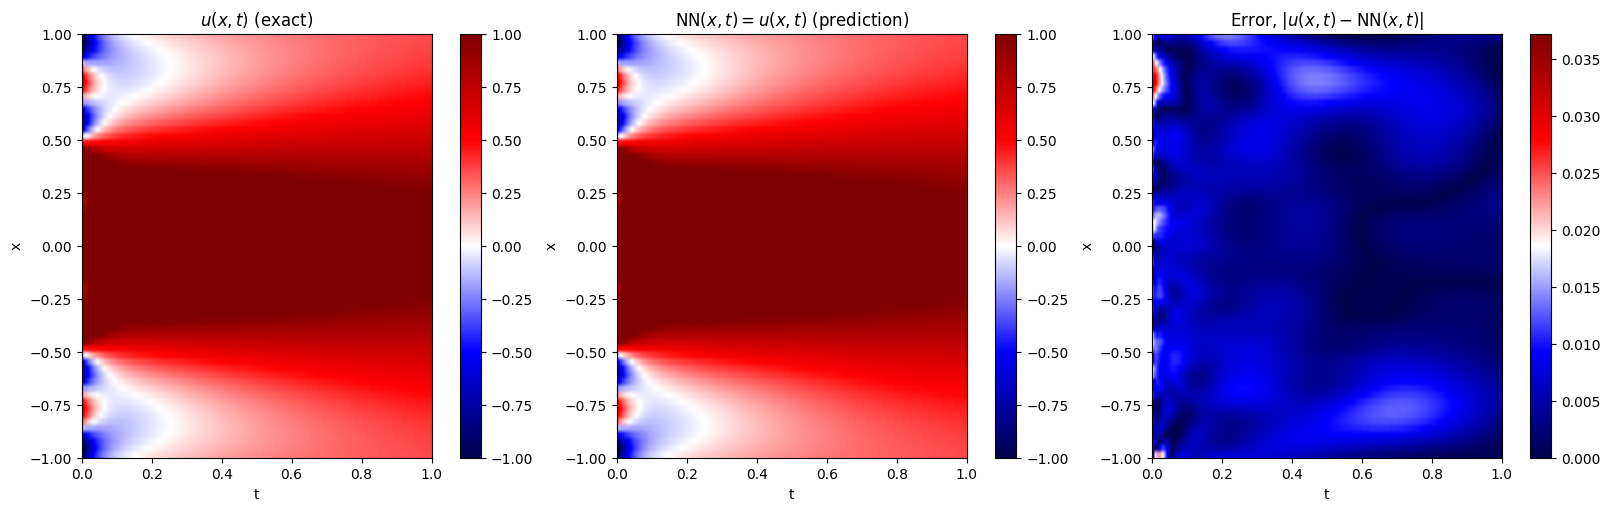

L2 err, all timesteps: 1.7838987440334637
Avg-L2 err, all timesteps: 3.399197301893033e-05
L2 err, t=0: 0.028109119718026748
L2 err, t=2: 0.03378505157603935


In [5]:
# 1. Create a grid for evaluation
x_eval = torch.linspace(-1, 1, 64, device=device).unsqueeze(1)
t_eval = torch.linspace(0, 1, 820, device=device).unsqueeze(1)
x_mesh, t_mesh = torch.meshgrid(x_eval.flatten(), t_eval.flatten(), indexing="ij")
x_flat = x_mesh.reshape(-1, 1)
t_flat = t_mesh.reshape(-1, 1)

# 2. Predict using the model
model.eval()
with torch.no_grad():
    u_pred_flat = model(x_flat, t_flat).cpu().numpy()

# 3. Compute the exact solution
u_exact_flat = manufactured_solution(x_flat, t_flat).cpu().numpy()

# 4. Reshape for plotting
u_pred = u_pred_flat.reshape(len(x_eval), len(t_eval))
u_exact = u_exact_flat.reshape(len(x_eval), len(t_eval))
l2_err = np.abs(u_exact - u_pred)

# 5. Plot
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1, 3, figsize=(16, 5), constrained_layout=True)

# Plot u_exact
im0 = axs[0].imshow(u_exact, extent=[t_eval.min(), t_eval.max(), x_eval.min(), x_eval.max()],
                    origin='lower', aspect='auto', cmap='seismic', vmin=-1, vmax=1)
axs[0].set_title(r"$u(x,t)$ (exact)")
axs[0].set_xlabel("t")
axs[0].set_ylabel("x")
fig.colorbar(im0, ax=axs[0])

# Plot u_pred
im1 = axs[1].imshow(u_pred, extent=[t_eval.min(), t_eval.max(), x_eval.min(), x_eval.max()],
                    origin='lower', aspect='auto', cmap='seismic', vmin=-1, vmax=1)
axs[1].set_title(r"NN$(x,t) = u(x,t)$ (prediction)")
axs[1].set_xlabel("t")
axs[1].set_ylabel("x")
fig.colorbar(im1, ax=axs[1])

# Plot error
im2 = axs[2].imshow(l2_err, extent=[t_eval.min(), t_eval.max(), x_eval.min(), x_eval.max()],
                    origin='lower', aspect='auto', cmap='seismic', vmin=0, vmax=np.max(l2_err))
axs[2].set_title(r"Error, $|u(x,t) - \mathrm{NN}(x,t)|$")
axs[2].set_xlabel("t")
axs[2].set_ylabel("x")
fig.colorbar(im2, ax=axs[2])

plt.show()


# Compute L2 errors
l2_err = np.sum((u_exact - u_pred)**2)
l2_err_t0 = np.sum((u_exact[0, :] - u_pred[0, :])**2)
l2_err_tmax = np.sum((u_exact[-1, :] - u_pred[-1, :])**2)

# Output error information
print(f'L2 err, all timesteps: {l2_err}')
print(f'Avg-L2 err, all timesteps: {l2_err/u_pred.size}')
print(f'L2 err, t=0: {l2_err_t0}')
print(f'L2 err, t={tmax}: {l2_err_tmax}')